# Импорт библиотек и модулей для расчета 

In [67]:
import numpy as np 
import sys
import os
from scipy import optimize
import CoolProp.CoolProp as CP
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from pathlib import Path

# Импорт модулей
from INPUT import data

# Импорт класса расчета 
from class_DpDz import DpDz

Зададим общее количество расчетных точек

In [68]:
Nx = 50

# Исследование зависимости градиента давления от паросодерания при постоянной температуре

Вводим термодинамические параметры 

In [69]:
research_1 = {
        'Substance': 'CO2',
        'Temperature': -10,
        'x': np.linspace(0.1, 0.9, Nx),
        'G': np.array([300, 400, 500, 600])
        }

Создадим экземпляр класса расчета и зададим параметры установки 

In [70]:
first_experimental_setup = DpDz(g=9.8155, ki=300, d=0.00142, value_fb=False, thermodinamic_params=research_1)

Запишем данные расчета в df 

In [71]:
calculated_data = []
for i in first_experimental_setup.calculate():
    df = pd.DataFrame(i)
    calculated_data.append(df)

Зададим путь к папке с экспериментальными данными

In [72]:
graph_9 = Path("/Users/andrey/Desktop/NIR/Datasets/Graph9")

Запишем экспериментальные данные в df

In [73]:
exp_df_9 = []
for file_path in graph_9.rglob('*'):
    if file_path.is_file():
        try:
            write = pd.read_csv(file_path, sep='\t', decimal='.')
            exp_df_9.append(write)
        except Exception as e:
            print(f"Ошибка: {e}")

Построим графики для сравнения расчетных и экспериментальных данных 

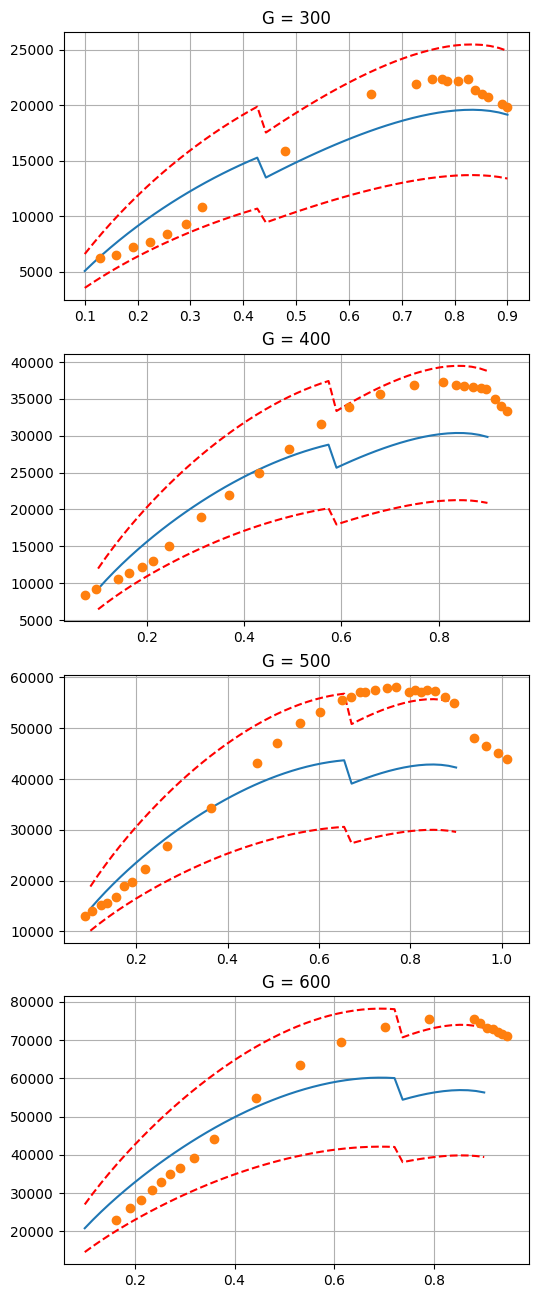

In [74]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(6, 16))

for i in range(len(calculated_data)):
    x = research_1['x']
    y = calculated_data[i]['DpDz']
    x_exp = exp_df_9[i]['X']
    y_exp = exp_df_9[i]['Y'] 
    ax[i].plot(x, y)
    ax[i].plot(x, 0.7 * y, color='red', linestyle='--')
    ax[i].plot(x, 1.3 * y, color='red', linestyle='--')
    ax[i].plot(x_exp, y_exp * 1000, marker='o', linestyle='')
    ax[i].set_title(f'G = {research_1["G"][i]}' )
    ax[i].grid()


# Исследование зависимости градиента давления от паросодерания при постоянном расходе

Зададим путь к папке с экспериментальными данным

In [75]:
graph_12 = Path("/Users/andrey/Desktop/NIR/Datasets/Graph12")

Получим экспериментальные данные 

In [76]:
data = []
# Числовой порядок для Gr файлов
gr_files = [f for f in graph_12.rglob('Dataset*.csv')]
gr_files_sorted = sorted(gr_files, key=lambda x: int(x.stem[7:]))

for file_path in gr_files_sorted:
    if file_path.is_file():
        try:
            write = pd.read_csv(file_path, sep='\t', decimal='.')
            data.append(write)
        except Exception as e:
            print(f"Ошибка: {e}")


Зададим массив исследуемых температур

In [77]:
T = np.array([0, -10, -20, -30, -35, -40])

Изменяя параметры в цикле рассчитаем зависимость для каждой температуры

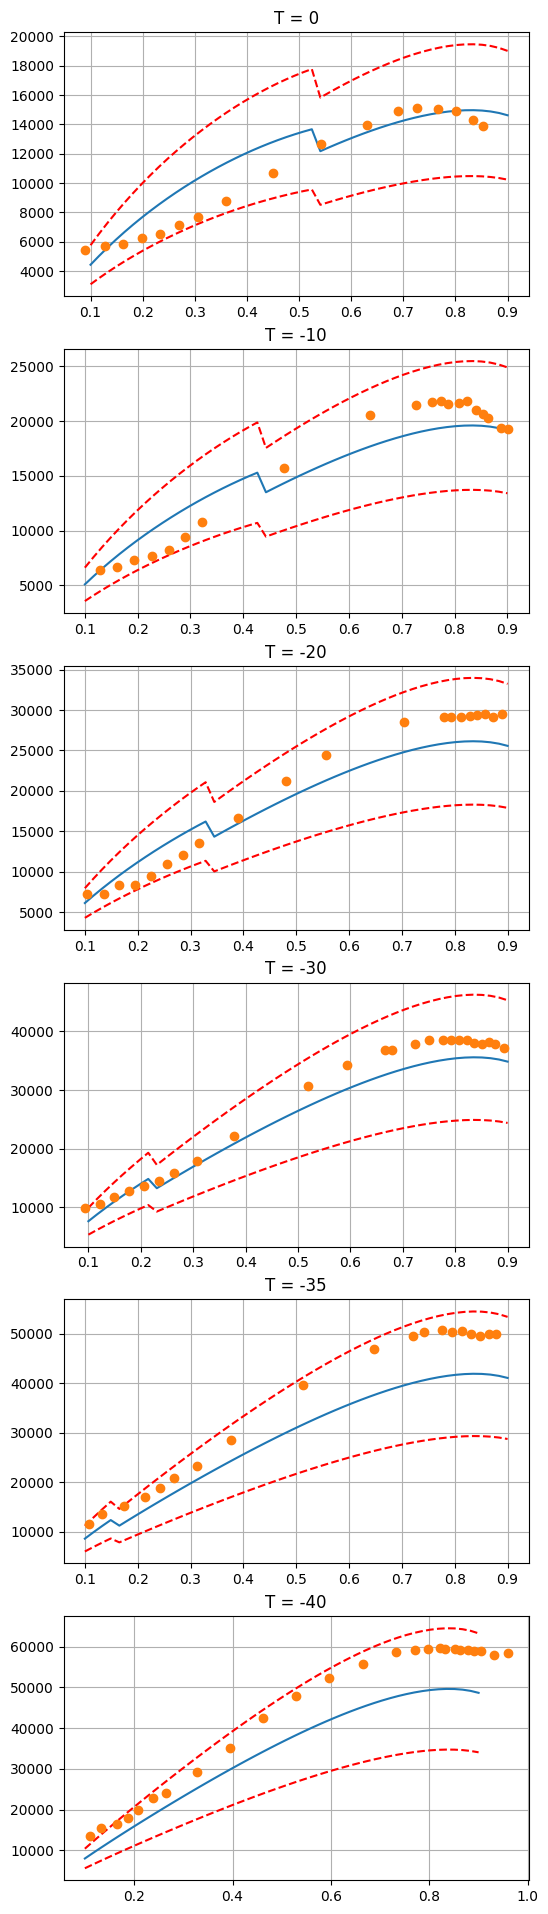

In [87]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(6, 24))

for i, t in enumerate(T):
    params_t = {
            'Substance': 'CO2',
            'Temperature': t,
            'G': np.array([300]),
            'x': np.linspace(0.1, 0.9, Nx),
        }
    
    result = DpDz(g=9.8155, ki=350, d=0.00142, value_fb=False, thermodinamic_params=params_t)
    result = result.calculate()
    
    df = pd.DataFrame(result)

    x = params_t['x']
    y = df['DpDz']

    x_exp = data[i]['X']
    y_exp = data[i]['Y'] * 1000

    ax[i].plot(x, y)
    ax[i].plot(x, 0.7 * y, color='red', linestyle='--')
    ax[i].plot(x, 1.3 * y, color='red', linestyle='--')
    ax[i].plot(x_exp, y_exp, marker='o', linestyle='')
    ax[i].set_title(f'T = {t}')
    ax[i].grid()

    